In [1]:
import torch
import torch.nn as nn
import tiktoken as tk
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
GPT_CONFIG_124M = {
    'emb_size':768,
    'context_length':256,
    'vocab_size':50257,
    'num_heads':12,
    'num_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False,
}

## **Import GPT model and other building blocks**

In [3]:
class MultiHeadAttention(nn.Module):
  def __init__(self, dim_in, dim_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (dim_out % num_heads == 0), "dim_out must be divisible by num_heads"

    self.dim_out = dim_out # final merged context vector embedding size
    self.num_heads = num_heads
    self.head_dim = dim_out//num_heads # embedding size of context vector in single head
    self.w_query = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_key = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_value = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.out_proj = torch.nn.Linear(dim_out, dim_out) # transform merged context_vectors into similar dimension size vectors
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, dim_in = x.shape
    queries = self.w_query(x)
    keys = self.w_key(x)
    values = self.w_value(x)  #shape (batch_size, num_tokens, dim_out)

    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim) #shape (batch_size, num_tokens, num_heads, head_dim)

    queries = queries.transpose(1,2)
    keys = keys.transpose(1,2)
    values = values.transpose(1,2) #shape (batch_size, num_heads, num_tokens, head_dim)

    attention_scores = queries @ keys.transpose(2,3)
    attention_scores.masked_fill_(self.mask.bool()[:num_tokens,:num_tokens], -torch.inf)

    attention_weights = torch.softmax(attention_scores/keys.shape[-1]**0.5, dim=-1)
    attention_weights = self.dropout(attention_weights)

    context_vectors = (attention_weights @ values).transpose(1,2) #transposing axis 1,2  since we have to merge the context vectors by num_heads and head_dim, so required shape will now be (batch_size, num_tokens, num_heads, head_dim)
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.dim_out)

    context_vectors = self.out_proj(context_vectors)

    return context_vectors

In [4]:
class LayerNorm(nn.Module):
  def __init__(self, emb_size):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_size))
    self.shift = nn.Parameter(torch.zeros(emb_size))

  def forward(self, x):
    mean = x.mean(keepdim=True, dim=-1)
    variance = x.var(keepdim=True, dim=-1, unbiased=False)
    norm_x = (x - mean)/torch.sqrt(variance + self.eps)
    return self.scale * norm_x + self.shift

In [5]:
class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x,3))
    ))

In [6]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_size'], 4 * cfg['emb_size']),
        GeLU(),
        nn.Linear(4 * cfg['emb_size'], cfg['emb_size'])
    )

  def forward(self, x):
    return self.layers(x)

In [7]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.mha = MultiHeadAttention(cfg['emb_size'], cfg['emb_size'], cfg['context_length'], cfg['drop_rate'], cfg['num_heads'], qkv_bias=cfg['qkv_bias'])
    self.layer_norm1 = LayerNorm(cfg['emb_size'])
    self.layer_norm2 = LayerNorm(cfg['emb_size'])
    self.ffn = FeedForward(cfg)
    self.dropout = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x
    x = self.layer_norm1(x)
    x = self.mha(x)
    x = self.dropout(x)
    x = x + shortcut

    shortcut = x
    x = self.layer_norm2(x)
    x = self.ffn(x)
    x = self.dropout(x)
    x = x + shortcut

    return x

In [8]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb_layer = nn.Embedding(cfg['vocab_size'], cfg['emb_size'])
    self.pos_emb_layer = nn.Embedding(cfg['context_length'], cfg['emb_size'])
    self.dropout_layer = nn.Dropout(cfg['drop_rate'])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['num_layers'])]
    )
    self.final_norm = LayerNorm(cfg['emb_size'])
    self.output_layer = nn.Linear(cfg['emb_size'], cfg['vocab_size'], bias=False)

  def forward(self, inp_tokens):
    batch_size, num_tokens = inp_tokens.shape
    token_emb = self.token_emb_layer(inp_tokens)
    pos_emb = self.pos_emb_layer(
        torch.arange(num_tokens, device=inp_tokens.device)
    )
    x = token_emb + pos_emb
    x = self.dropout_layer(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.output_layer(x)

    return logits

In [9]:
def generate_text_tokens(model, inp_tokens, max_tokens, context_size):
  for _ in range(max_tokens):
    cropped_tokens = inp_tokens[:,-context_size:]
    with torch.no_grad():
      logits = model(cropped_tokens)

    logits = logits[:,-1,:]
    prob = torch.softmax(logits, dim=-1)
    token_id = torch.argmax(prob, dim=-1, keepdim=True)
    inp_tokens = torch.cat((inp_tokens, token_id), dim=1)

  return inp_tokens

## **Utility functions**

In [10]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text)
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(tokens, tokenizer):
  token_list = tokens.squeeze(0).tolist()
  decoded = tokenizer.decode(token_list)
  return decoded

## **Text Generation Loss**

In [11]:
inp_text1 = "every effort moves"
inp_text2 = "I really like"

target_text1 = " effort moves you"
target_text2 = " really like chocolate"

In [12]:
tokenizer = tk.get_encoding("gpt2")

In [13]:
inp1 = text_to_token_ids(inp_text1, tokenizer)
inp2 = text_to_token_ids(inp_text2, tokenizer)

target1 = text_to_token_ids(target_text1, tokenizer)
target2 = text_to_token_ids(target_text2, tokenizer)

In [14]:
target1, target2

(tensor([[3626, 6100,  345]]), tensor([[ 1107,   588, 11311]]))

In [15]:
inp = torch.cat((inp1, inp2), dim=0)
target = torch.cat((target1 , target2), dim=0)

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
with torch.no_grad():
  pred = model(inp)

print(pred.shape)

torch.Size([2, 3, 50257])


In [17]:
probs = torch.softmax(pred, dim=-1)
probs.shape

torch.Size([2, 3, 50257])

In [18]:
max_tokens = torch.argmax(probs, dim=-1, keepdim=True)
output_tokens = max_tokens
print(output_tokens)

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [19]:
print(f'Original text: {token_ids_to_text(target[0], tokenizer)}')
print(f'Predicted text: {token_ids_to_text(output_tokens[0].squeeze(-1), tokenizer)}')

Original text:  effort moves you
Predicted text:  Armed heNetflix


In [20]:
#probability score of target token ids
batch_target_idx = 0
prob_text1 = probs[batch_target_idx, [0,1,2], target[batch_target_idx]]

batch_target_idx = 1
prob_text2 = probs[batch_target_idx, [0,1,2], target[batch_target_idx]]

print(prob_text1)
print(prob_text2)

tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [21]:
#LETS CALCULATE TEXT LOSS
##since we have already selected the probabilities of token indices
##first lets convert the probabilities to log probs and concatenate them
log_prob = torch.log(torch.cat((prob_text1, prob_text2), dim=-1))

##lets take average now
avg_log_prob = torch.mean(log_prob)

loss = avg_log_prob * -1

loss

tensor(10.7940)

In [22]:
#lets use cross_entropy funcntion to perform the above steps
pred_flat = torch.flatten(pred, 0, 1)
target_flat = torch.flatten(target)

pred_flat.shape, target_flat.shape

(torch.Size([6, 50257]), torch.Size([6]))

In [23]:
cross_entropy_loss = torch.nn.functional.cross_entropy(pred_flat, target_flat)
cross_entropy_loss

tensor(10.7940)

In [24]:
#lets calculate perplexity
perplexity = torch.exp(cross_entropy_loss)
perplexity

tensor(48725.8203)

## **Training and Validation set losses**

In [25]:
class GPTDataset(Dataset):
  def __init__(self, text, tokenizer, max_length, stride):
    self.inputs = []
    self.targets = []

    encoded_text = tokenizer.encode(text)

    for i in range(0,len(encoded_text) - max_length, stride):
      input = encoded_text[i:i+max_length]
      target = encoded_text[i+1:i+max_length+1]

      self.inputs.append(torch.tensor(input))
      self.targets.append(torch.tensor(target))

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    return self.inputs[index], self.targets[index]

In [26]:
def create_dataloader(text, batch_size=8, max_length=4, stride=4, drop_last=True, num_workers=0, shuffle=True):
  tokenizer = tk.get_encoding('gpt2')
  dataset = GPTDataset(text,tokenizer, max_length, stride)

  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

  return dataloader

In [27]:
file_path = "/content/drive/My Drive/LLM/Data/the-verdict.txt"
with open(file_path,"r",encoding="utf-8") as f:
  raw_text = f.read()

print(len(raw_text))

20479


In [28]:
split_ratio = 0.9
train_text = raw_text[ : int(split_ratio * len(raw_text))]
val_text = raw_text[int(split_ratio * len(raw_text)) : ]

In [29]:
train_loader = create_dataloader(train_text, batch_size=2, max_length=GPT_CONFIG_124M['context_length'], stride=GPT_CONFIG_124M['context_length'])
val_loader = create_dataloader(val_text, batch_size=2, max_length=GPT_CONFIG_124M['context_length'], stride=GPT_CONFIG_124M['context_length'])

In [30]:
for x,y in train_loader:
  print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [31]:
for x,y in val_loader:
  print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])


In [32]:
def ce_batch_loss_calc(input_batch, target_batch, model, device):
  """
  ARGS
  input_batch: torch.tensor 2-D
  target_batch: torch.tensor 2-D
  model: GPTModel
  device: torch.device - 'cuda' or 'cpu'

  calculates cross-entropy loss for a batch
  """
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits_batch = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits_batch.flatten(0, 1), target_batch.flatten())

  return loss

In [33]:
def calc_loss_dataloader(loader, model, device, num_batches=None):
  """
  ARGS
  loader: dataloader
  model: GPTModel
  device: torch.device - 'cuda' or 'cpu'
  num_batches: integer

  calculates mean cross entropy loss across all the batches of the dataloader
  """
  total_loss = 0
  if len(loader) == 0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(loader)
  elif num_batches < 0:
    num_batches = float('nan')
  else:
    num_batches = min(num_batches, len(loader))

  for i, (x, y) in enumerate(loader):
    if i < num_batches:
      loss = ce_batch_loss_calc(x, y, model, device)
      total_loss += loss
    else:
      break

  return total_loss/num_batches

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_dataloader(train_loader, model=model, device = device)
  val_loss = calc_loss_dataloader(val_loader, model=model, device = device)

print(f'Train loss: {train_loss}')
print(f'Validation loss: {val_loss}')

Train loss: 10.987584114074707
Validation loss: 10.981104850769043


## **LLM Pretraining**

In [36]:
def train_model_simple(model, train_loader, val_loader, device, optimizer, epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_loss_arr, val_loss_arr, track_tokens_seen = [], [], []
  global_step, tokens_seen = -1, 0

  for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
      model.zero_grad()
      train_loss = ce_batch_loss_calc(x, y, model, device)
      train_loss.backward()
      optimizer.step()
      tokens_seen += x.numel()
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f'Train loss after epoch {epoch} (Step: {global_step}): {train_loss:.3f}')
        print(f'Val loss after epoch {epoch} (Step: {global_step}): {val_loss:.3f}')
        print(f'Number of tokens seen after epoch {epoch} (Step: {global_step})')

    generate_and_print_sample(model, start_context, tokenizer, device)

  return train_loss_arr, val_loss_arr, track_tokens_seen

In [37]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_dataloader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_dataloader(val_loader, model, device, eval_iter)
  model.train()

  return train_loss, val_loss

In [38]:
def generate_and_print_sample(model, start_context, tokenizer, device):
  model.eval()
  context_size = model.trf_blocks[0].mha.mask.shape[0] ##model.pos_emb.shape[0]
  encoded_text = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    op_tokens = generate_text_tokens(model, encoded_text, max_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(op_tokens, tokenizer)

  print(decoded_text.replace('\n',' '))
  model.train()

In [39]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, device, optimizer, epochs=10, eval_freq=5, eval_iter=5, start_context='Every effort moves you', tokenizer=tokenizer)

Train loss after epoch 0 (Step: 0): 9.818
Val loss after epoch 0 (Step: 0): 9.930
Number of tokens seen after epoch 0 (Step: 0)
Train loss after epoch 0 (Step: 5): 7.920
Val loss after epoch 0 (Step: 5): 8.336
Number of tokens seen after epoch 0 (Step: 5)
Every effort moves you,,,,,,,,,,,,.                                     
Train loss after epoch 1 (Step: 10): 6.585
Val loss after epoch 1 (Step: 10): 7.046
Number of tokens seen after epoch 1 (Step: 10)
Train loss after epoch 1 (Step: 15): 5.984
Val loss after epoch 1 (Step: 15): 6.598
Number of tokens seen after epoch 1 (Step: 15)
Every effort moves you, the, and, the, the, the, and, the. ", the,,, the, and, the,, the,, the, and, the, the,, the, and,,,,, the
Train loss after epoch 2 (Step: 20): 15.871
Val loss after epoch 2 (Step: 20): 15.947
Number of tokens seen after epoch 2 (Step: 20)
Train loss after epoch 2 (Step: 25): 5.578
Val loss after epoch 2 (Step: 25): 6.453
Number of tokens seen after epoch 2 (Step: 25)
Every effort mo

## **Controlling LLM Output Randomness**

In [40]:
vocab = {
    "closer":0,
    "every":1,
    "effort":2,
    "forward":3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "toward":7,
    "you":8
}

inverse_vocab = {v:k for k,v in vocab.items()}

In [41]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [42]:
#approach till now (using highest prob to select next token)
probs = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probs).item()
print(inverse_vocab[next_token_id])

forward


In [43]:
#sampling from probability distribution using multinomial
torch.manual_seed(123)
next_token_id = torch.multinomial(probs, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [44]:
sample_token_ids = [torch.multinomial(probs, num_samples=1) for _ in range(1000)]
counts = torch.bincount(torch.tensor(sample_token_ids))
for i, count in enumerate(counts):
  print(f'{inverse_vocab[i]}: {count}')

closer: 71
every: 2
effort: 0
forward: 544
inches: 2
moves: 1
pizza: 0
toward: 376
you: 4


### Temperature Scaling

In [45]:
#scale logits by values greater than 0 before applying softmax to ajust the probability distribution
temperature = 2
scaled_logits = next_token_logits/temperature
softmax_probs = torch.softmax(scaled_logits, dim=0)

sample_token_ids = [torch.multinomial(softmax_probs, num_samples=1) for _ in range(1000)]
counts = torch.bincount(torch.tensor(sample_token_ids))
for i, count in enumerate(counts):
  print(f'{inverse_vocab[i]}: {count}')

closer: 142
every: 24
effort: 7
forward: 417
inches: 44
moves: 3
pizza: 2
toward: 325
you: 36


In [46]:
#lets try higher temperature for more uniform distribution
temperature = 5
scaled_logits = next_token_logits/temperature
softmax_probs = torch.softmax(scaled_logits, dim=0)

sample_token_ids = [torch.multinomial(softmax_probs, num_samples=1) for _ in range(1000)]
counts = torch.bincount(torch.tensor(sample_token_ids))
for i, count in enumerate(counts):
  print(f'{inverse_vocab[i]}: {count}')

closer: 164
every: 87
effort: 52
forward: 245
inches: 85
moves: 44
pizza: 39
toward: 203
you: 81


In [47]:
#lets try temperature lower than 1 for more sharper distribution
temperature = 0.2
scaled_logits = next_token_logits/temperature
softmax_probs = torch.softmax(scaled_logits, dim=0)

sample_token_ids = [torch.multinomial(softmax_probs, num_samples=1) for _ in range(1000)]
counts = torch.bincount(torch.tensor(sample_token_ids))
for i, count in enumerate(counts):
  print(f'{inverse_vocab[i]}: {count}')

closer: 0
every: 0
effort: 0
forward: 927
inches: 0
moves: 0
pizza: 0
toward: 73


In [48]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits/temperature
  scaled_probs = torch.softmax(scaled_logits, dim=0)
  return scaled_probs

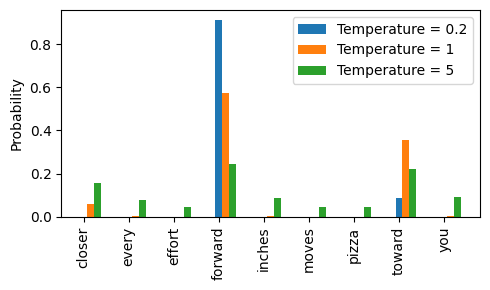

In [49]:
#lets visualize this using bar chart for different temperatures
import matplotlib.pyplot as plt
temperatures = [0.2, 1, 5]
scaled_probs = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probs[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### Top-k sampling

In [50]:
top_k=3
top_logits, top_idx = torch.topk(next_token_logits, top_k)
print(top_logits)
print(top_idx)

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [51]:
masked_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)

masked_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [52]:
top_k_softmax_probs = torch.softmax(masked_logits, dim=0)
top_k_softmax_probs

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

### Generate fn

In [53]:
def generate(model, inp_tokens, context_size, max_tokens, temperature=0.0, top_k=None, eos_id=None):
  for i in range(max_tokens):
    cond_inp = inp_tokens[:,-context_size:]
    with torch.no_grad():
      logits = model(cond_inp)
    logits = logits[:,-1,:]

    if top_k is not None:
      top_logits, top_idx = torch.topk(logits, top_k)
      logits = torch.where(
          condition=logits<top_logits[:,-1],
          input=torch.tensor(float('-inf')),
          other=logits
      )

    if temperature > 0:
      scaled_logits = logits / temperature
      probs = torch.softmax(scaled_logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    inp_tokens = torch.cat((inp_tokens, idx_next), dim=1)

  return inp_tokens

In [54]:
torch.manual_seed(123)
model.to('cpu')
model.eval()
output_tokens = generate(
    model,
    inp_tokens=text_to_token_ids("Every effort moves you", tokenizer),
    context_size=GPT_CONFIG_124M['context_length'],
    max_tokens=15,
    temperature=1.4,
    top_k=25
)

print(token_ids_to_text(output_tokens, tokenizer))

Every effort moves you know began to happen a hint of--I looked on my dear; and


## **Saving and Loading Model Weights**

In [55]:
### saving and loading only model
"""
torch.save(model.state_dict(), "/content/drive/My Drive/LLM/Data/model.pth")
model = GPTModel(GPT_CONFIG_124M)
checkpoint = torch.load("model.pth", map_location=device)
model.load_state_dict(checkpoint)
"""

'\ntorch.save(model.state_dict(), "/content/drive/My Drive/LLM/Data/model.pth")\nmodel = GPTModel(GPT_CONFIG_124M)\ncheckpoint = torch.load("model.pth", map_location=device)\nmodel.load_state_dict(checkpoint)\n'

In [75]:
### saving model and optimizer
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
}, "/content/drive/My Drive/LLM/Data/model_and_optimizer.pth")

In [57]:
#loading model ad optimizer parameters
checkpoint = torch.load("/content/drive/My Drive/LLM/Data/model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

GPTModel(
  (token_emb_layer): Embedding(50257, 768)
  (pos_emb_layer): Embedding(256, 768)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_

## **Loading OpenAI Pretrained Weights**

In [58]:
import urllib.request
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
filename = f"/content/drive/My Drive/LLM/Notebooks/{url.split('/')[-1]}"
urllib.request.urlretrieve(url, filename)

('/content/drive/My Drive/LLM/Notebooks/gpt_download.py',
 <http.client.HTTPMessage at 0x7e4e0e37f410>)

In [59]:
import sys
sys.path.append('/content/drive/My Drive/LLM/Notebooks')

In [60]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir='gpt2')

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 103kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.96MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 125kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:46<00:00, 10.6MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 6.56MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.63MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.58MiB/s]


In [61]:
print(f'Settings: {settings}')
print(f'Params dict keys: {params.keys()}')

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Params dict keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [62]:
print(params['wte'])
print(f"Shape: {params['wte'].shape}")

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Shape: (50257, 768)


In [63]:
model_configs = {
    'gpt2-small (124M)': {
        'emb_size':768,
        'num_heads':12,
        'num_layers':12,
    },
    'gpt2-medium (355M)': {
        'emb_size':1024,
        'num_heads':16,
        'num_layers':24,
    },
    'gpt2-large (774M)': {
        'emb_size':1280,
        'num_heads':20,
        'num_layers':36,
    },
    'gpt2-xl (1558M)': {
        'emb_size':1600,
        'num_heads':25,
        'num_layers':48,
    }
}

In [64]:
model_name = 'gpt2-small (124M)'
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

NEW_CONFIG.update({'context_length':1024})
NEW_CONFIG.update({'qkv_bias': True})

In [65]:
print(NEW_CONFIG)

{'emb_size': 768, 'context_length': 1024, 'vocab_size': 50257, 'num_heads': 12, 'num_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}


In [66]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (token_emb_layer): Embedding(50257, 768)
  (pos_emb_layer): Embedding(1024, 768)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_qu

In [67]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f'Shape mismatch. Left: {left.shape}. Right: {right.shape}')
  return torch.nn.Parameter(torch.tensor(right))

In [68]:
def load_parameters(gpt, params):
  gpt.token_emb_layer.weight = assign(gpt.token_emb_layer.weight, params['wte'])
  gpt.pos_emb_layer.weight = assign(gpt.pos_emb_layer.weight, params['wpe'])

  #transformer blocks' parameters loading
  for b in range(len(params['blocks'])):
    #each blocks' mha qkv weights
    q_w, k_w, v_w = np.split(
        params['blocks'][b]['attn']['c_attn']['w'], 3, axis=-1
    )
    gpt.trf_blocks[b].mha.w_query.weight = assign(
        gpt.trf_blocks[b].mha.w_query.weight, q_w.T
    )
    gpt.trf_blocks[b].mha.w_key.weight = assign(
        gpt.trf_blocks[b].mha.w_key.weight, k_w.T
    )
    gpt.trf_blocks[b].mha.w_value.weight = assign(
        gpt.trf_blocks[b].mha.w_value.weight, v_w.T
    )

    #each blocks' mha qkv bias
    q_b, k_b, v_b = np.split(
        params['blocks'][b]['attn']['c_attn']['b'], 3, axis=-1
    )
    gpt.trf_blocks[b].mha.w_query.bias = assign(
        gpt.trf_blocks[b].mha.w_query.bias, q_b
    )
    gpt.trf_blocks[b].mha.w_key.bias = assign(
        gpt.trf_blocks[b].mha.w_key.bias, k_b
    )
    gpt.trf_blocks[b].mha.w_value.bias = assign(
        gpt.trf_blocks[b].mha.w_value.bias, v_b
    )

    #each blocks' mha out_proj layer's weight and bias
    gpt.trf_blocks[b].mha.out_proj.weight = assign(
        gpt.trf_blocks[b].mha.out_proj.weight, params['blocks'][b]['attn']['c_proj']['w'].T
    )
    gpt.trf_blocks[b].mha.out_proj.bias = assign(
        gpt.trf_blocks[b].mha.out_proj.bias, params['blocks'][b]['attn']['c_proj']['b']
    )

    #each blocks' ff wieghts and biases
    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
        gpt.trf_blocks[b].ffn.layers[0].weight, params['blocks'][b]['mlp']['c_fc']['w'].T
    )
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
        gpt.trf_blocks[b].ffn.layers[0].bias, params['blocks'][b]['mlp']['c_fc']['b']
    )
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
        gpt.trf_blocks[b].ffn.layers[2].weight, params['blocks'][b]['mlp']['c_proj']['w'].T
    )
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
        gpt.trf_blocks[b].ffn.layers[2].bias, params['blocks'][b]['mlp']['c_proj']['b']
    )

    #each blocks' layer_norms scale and shift
    gpt.trf_blocks[b].layer_norm1.scale = assign(
        gpt.trf_blocks[b].layer_norm1.scale, params['blocks'][b]['ln_1']['g']
    )
    gpt.trf_blocks[b].layer_norm1.shift = assign(
        gpt.trf_blocks[b].layer_norm1.shift, params['blocks'][b]['ln_1']['b']
    )
    gpt.trf_blocks[b].layer_norm2.scale = assign(
        gpt.trf_blocks[b].layer_norm2.scale, params['blocks'][b]['ln_2']['g']
    )
    gpt.trf_blocks[b].layer_norm2.shift = assign(
        gpt.trf_blocks[b].layer_norm2.shift, params['blocks'][b]['ln_2']['b']
    )

  #gpt's final_layer_norm
  gpt.final_norm.scale = assign(
        gpt.final_norm.scale, params['g']
  )
  gpt.final_norm.shift = assign(
        gpt.final_norm.shift, params['b']
  )
  gpt.output_layer.weight = assign(
      gpt.output_layer.weight, params['wte']
  )

In [69]:
load_parameters(gpt, params)
gpt.to(device)

GPTModel(
  (token_emb_layer): Embedding(50257, 768)
  (pos_emb_layer): Embedding(1024, 768)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_qu

In [73]:
torch.manual_seed(123)
output = generate(
    gpt,
    text_to_token_ids("Every effort moves you", tokenizer).to(device),
    NEW_CONFIG['context_length'],
    25,
    1.5,
    50
)

print(token_ids_to_text(output, tokenizer))

Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle
